#GPU


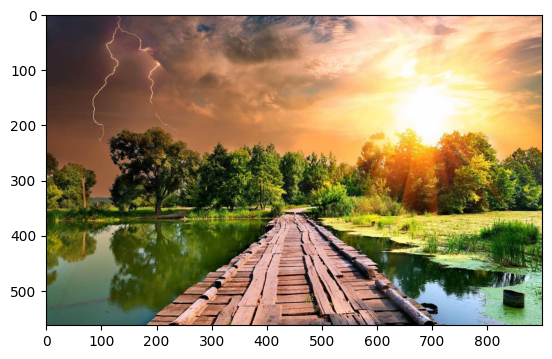

uint8


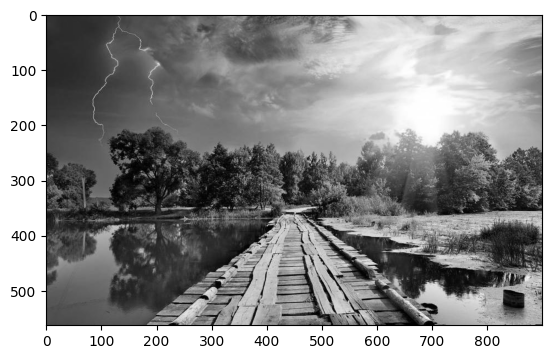

Time 1.5739755630493164


In [2]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

hostInp=plt.imread("images/image3.jpg")
plt.imshow(hostInp)
plt.show()
print(hostInp.dtype)
(H,W,C) = hostInp.shape

t1 = time.time()
pixelcount= H*W
hostInp=hostInp.reshape((pixelcount,3))

devOut = cuda.device_array((pixelcount, C), np.uint8)



hostOut=np.zeros((H,W,C),np.uint8)

devInp=cuda.to_device(hostInp)

@cuda.jit

def grayscale(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
    dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g


blockSize = 64
gridSize = pixelcount // blockSize
grayscale[gridSize, blockSize](devInp, devOut)
cuda.synchronize()
hostOut = devOut.copy_to_host()

t2 = time.time()
#plt.imshow(hostOut)
plt.imshow(hostOut.reshape(H,W,C))
plt.show()

print(f"Time {t2-t1}")

#CPU

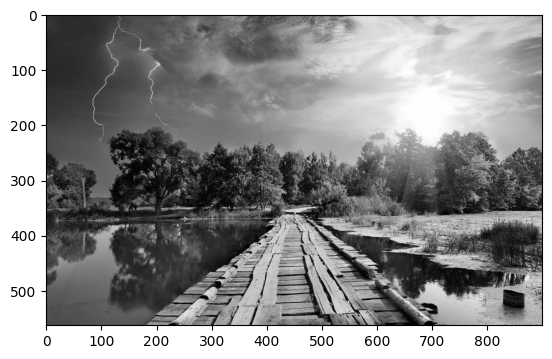

Time 1.702965259552002


In [3]:
image=plt.imread("images/image3.jpg")
(H,W,C) = image.shape

t1 = time.time()
array = np.zeros((H,W,C),np.uint8)

for i in range(H):
  for j in range(W):
    g = np.uint8((float(image[i][j][0]) + float(image[i][j][1]) + float(image[i][j][2])) // 3)
    array[i][j]= [g]*3
    del g

t2 = time.time()
plt.imshow(array)
plt.show()

print(f"Time {t2-t1}")


In [4]:
print((H,W,C))

(563, 900, 3)


In [5]:
def grayscale_cuda(block_sizes):
    hostInp = plt.imread('images/image3.jpg')
    (H, W, C) = hostInp.shape
    pixelcount = H * W
    hostInp = hostInp.reshape((pixelcount, C))


    devOut = cuda.device_array((pixelcount, C), np.uint8)
    hostOut = np.zeros((H, W, C), np.uint8)

    devInp = cuda.to_device(hostInp)

    times = []
    blocks = []

    for blockSize in block_sizes:
        gridSize = pixelcount // blockSize
        cuda.synchronize()
        t1 = time.time()

        grayscale[gridSize, blockSize](devInp, devOut)
        cuda.synchronize()
        t2 = time.time()
        hostOut = devOut.copy_to_host()


        times.append(t2 - t1)
        blocks.append(blockSize)

    return times, blocks

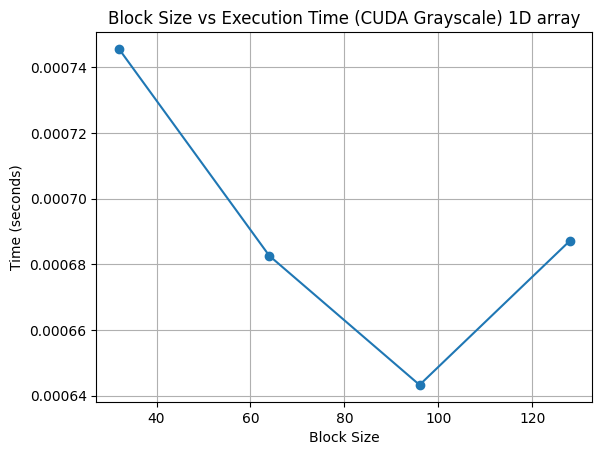

In [20]:
block_sizes = [32*(i+1) for i in range(4)]


times , blocks = grayscale_cuda(block_sizes)

plt.plot(blocks, times, marker='o')
plt.xlabel('Block Size')
plt.ylabel('Time (seconds)')
plt.title('Block Size vs Execution Time (CUDA Grayscale) 1D array')
plt.grid(True)
plt.show()

In [13]:

@cuda.jit
def grayscale2d(src, dst):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    g = np.uint8((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
    dst[tidx, tidy, 0] = dst[tidx, tidy, 1] = dst[tidx, tidy, 2] = g


def grayscale_cuda2d(block_sizes):
    hostInp = plt.imread('images/image3.jpg')
    (H, W, C) = hostInp.shape
    #pixelcount = H * W


    devOut = cuda.device_array((H ,W , C), np.uint8)
    hostOut = np.zeros((H, W, C), np.uint8)

    devInp = cuda.to_device(hostInp)

    times = []
    blocks = []

    for blockSize in block_sizes:
        gridSizeX = (H) // blockSize[0]
        gridSizeY = (W) // blockSize[1]

        gridSize = (gridSizeX, gridSizeY)
        imageSize = (gridSizeX*blockSize[0], gridSizeY*blockSize[1],C)
        print(f"Grid = {gridSize}, Block = { blockSize}")
        print(f"Image = { imageSize }, real image = {(H, W, C)}")
        cuda.synchronize()
        t1 = time.time()

        grayscale2d[gridSize, blockSize](devInp, devOut)
        cuda.synchronize()
        t2 = time.time()
        hostOut = devOut.copy_to_host()


        times.append(t2 - t1)
        blocks.append(blockSize[0])

    return times, blocks

[(8, 8), (16, 16), (24, 24), (32, 32)]
Grid = (70, 112), Block = (8, 8)
Image = (560, 896, 3), real image = (563, 900, 3)
Grid = (35, 56), Block = (16, 16)
Image = (560, 896, 3), real image = (563, 900, 3)
Grid = (23, 37), Block = (24, 24)
Image = (552, 888, 3), real image = (563, 900, 3)
Grid = (17, 28), Block = (32, 32)
Image = (544, 896, 3), real image = (563, 900, 3)


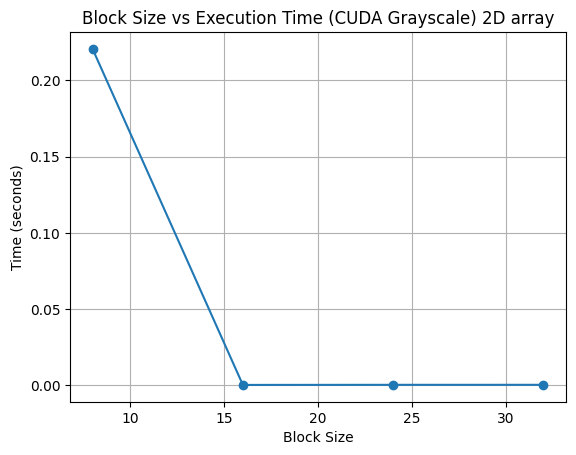

In [14]:
block_sizes = [(8, 8), (16, 16), (24, 24), (32, 32)]
print(block_sizes)
times , blocks = grayscale_cuda2d(block_sizes)




plt.plot(blocks, times, marker='o')
plt.xlabel('Block Size')
plt.ylabel('Time (seconds)')
plt.title('Block Size vs Execution Time (CUDA Grayscale) 2D array')
plt.grid(True)
plt.show()